##Introduction

Sentiment analysis is a Natural Language Processing (NLP) task that aims to determine the sentiment expressed in a piece of text, such as positive, neutral, or negative. In this project, we analyze Amazon product reviews to classify user opinions into three sentiment categories.

The main challenges of this dataset are:

**Text preprocessing** is required to clean and normalize the reviews (removing stopwords, punctuation, lemmatization, etc.).

**Imbalanced data**: most reviews are positive, while neutral and negative classes are underrepresented. This can bias the model toward predicting only the majority class.

To handle these issues, we applied:

**Vectorization (TF-IDF)** to convert text into numerical features.

**SMOTE (Synthetic Minority Oversampling Technique)** to balance the dataset by generating synthetic samples of minority classes.

**Logistic Regression** as the baseline classifier.

**GridSearchCV combined with SMOTE** in a pipeline to optimize hyperparameters and improve classification performance.

This approach allows us to evaluate whether resampling and hyperparameter tuning lead to better predictions, especially for minority classes.

###Import Required Libraries

We start by importing the necessary Python libraries for our sentiment analysis task:

- **pandas & numpy** → For data manipulation and handling.
- **re & string** → For cleaning text using regular expressions and string operations.
- **nltk** → For Natural Language Processing tasks like tokenization, stopwords removal, and lemmatization.
- **scikit-learn** → For splitting data, vectorizing text, training models, and evaluating performance.
- **seaborn & matplotlib** → For visualizing results, such as confusion matrices.





In [22]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from collections import Counter


## Download NLTK Resources

Before preprocessing text, we need to download some essential **NLTK corpora and models**:
- `stopwords`: list of common words (like *the, is, in*) that are usually removed during preprocessing.
- `punkt_tab`: tokenizer models for sentence and word splitting.
- `wordnet`: lexical database required for **lemmatization** (reducing words to their base form).

These resources are downloaded once and then used across the project.


In [2]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

###  Load and Prepare the Dataset

We load the Amazon reviews dataset from a CSV file using **pandas**.

- Only two columns are retained:  
  - `reviews.text` → the main review text.
  - `reviews.rating` → the numeric rating given by the customer.
- Missing values in these columns are removed to ensure data quality.

This keeps our dataset focused only on the features we need for sentiment classification.


In [3]:
df = pd.read_csv("/content/amazon_reviews.csv")
print(df.head())

                     id       asins   brand                  categories  \
0  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
1  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
2  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
3  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
4  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   

  colors             dateAdded           dateUpdated  \
0    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
1    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
2    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
3    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
4    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   

                  dimension  ean                         keys  ...  \
0  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qjdu3ky  ...   
1  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qjdu3ky  ...   
2 

In [4]:
df.columns

Index(['id', 'asins', 'brand', 'categories', 'colors', 'dateAdded',
       'dateUpdated', 'dimension', 'ean', 'keys', 'manufacturer',
       'manufacturerNumber', 'name', 'prices', 'reviews.date',
       'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating',
       'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'sizes',
       'upc', 'weight'],
      dtype='object')

id → Unique identifier for the product (or entry) in the dataset.

asins → Amazon Standard Identification Number — unique Amazon product code.

brand → Brand name of the product (e.g., Samsung, Nike).

categories → List of product categories (e.g., “Electronics > Phones”).

colors → Colors available for the product (if applicable).

dimension → Physical dimensions of the product (size measurements).

ean → European Article Number — another product identifier.

keys → Possibly keywords associated with the product.

manufacturer → Name of the company that made the product.

manufacturerNumber → Manufacturer's internal reference number.

name → Name/title of the product.

sizes → Sizes available (clothes, shoes, etc.).

upc → Universal Product Code — another identifier (often barcode number).

weight → Product weight.

prices → Price of the product

reviews.date → Date when the review was posted.

reviews.doRecommend → Boolean (True/False) — whether the reviewer recommends the product.

reviews.numHelpful → Number of people who found the review helpful.

reviews.rating → Numeric rating .

reviews.sourceURLs → URL to the review’s source.

reviews.text → The actual review content (main text to use for NLP).

reviews.title → Title/summary of the review.

reviews.userCity → Reviewer’s city.

reviews.userProvince → Reviewer’s province/state.

reviews.username

dateAdded → Date the product was added to the dataset/platform.

dateUpdated → Date product info was last updated.

In [5]:
# Keep only the relevant columns
df = df[['reviews.text', 'reviews.rating']]

# Drop missing values
df.dropna(subset=['reviews.text', 'reviews.rating'], inplace=True)

##Create Sentiment Labels from Ratings

#### Convert Ratings to Sentiment Labels

We define a function to map numeric ratings (1–5 stars) to categorical sentiments:

- **Positive** → ratings 4 and 5
- **Neutral** → rating 3
- **Negative** → ratings 1 and 2

We then apply this function to create a new column `sentiment`, which will be used as the target variable in our model.


In [6]:
def rating_to_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

df['sentiment'] = df['reviews.rating'].apply(rating_to_sentiment)


### Class Distribution Analysis



In [7]:
df['sentiment'].value_counts()

,count
sentiment,
positive,977
neutral,124
negative,76


The sentiment classes are imbalanced, with **positive reviews dominating**.  
This is common in product review datasets, since satisfied customers are more likely to leave reviews.  


### Text Cleaning and Preprocessing

This function processes the text in several steps:

1. **Lowercasing** → avoids case sensitivity issues.
2. **Punctuation Removal** → removes unnecessary characters.
3. **Tokenization** → splits text into individual words using NLTK's tokenizer.
4. **Stopwords Removal** → removes common words (like "the", "is") that don't add meaning.
5. **Lemmatization** → converts words to their base form.

The cleaned text is stored in a new column `clean_text`.

This ensures our model receives normalized, noise-free input for better accuracy.


In [8]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lowercase
    text = text.lower()
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords & lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['reviews.text'].apply(clean_text)


## Train/Test Split

#### Splitting the Dataset

We split the dataset into:
- **Training set (80%)** → for fitting the model.
- **Test set (20%)** → for evaluating the model.

We use `stratify` to ensure that the class distribution (positive, neutral, negative) remains balanced in both sets.

This prevents bias during training and testing.


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'],
    df['sentiment'],
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment']
    )


## Text Vectorization with TF-IDF

We convert cleaned text into numerical vectors using **TF-IDF** (Term Frequency - Inverse Document Frequency):

- **TF** → how often a word appears in a document.
- **IDF** → how rare the word is across the dataset.

This representation allows the model to capture the importance of each word in predicting sentiment.


In [10]:
vectorizer = TfidfVectorizer(min_df=3,     # drop very rare terms
    ngram_range=(1,2) )
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

### Handling Class Imbalance with SMOTE

Our dataset is **imbalanced** (positive reviews dominate).  
To avoid the model being biased toward the majority class, we apply **SMOTE (Synthetic Minority Oversampling Technique)**:

- **Idea**: Instead of duplicating minority samples, SMOTE generates **synthetic samples** by interpolating between existing ones.  
- **`sampling_strategy='not majority'`**: resample all classes except the majority (positive) until they are balanced relative to each other.  
- This creates a more balanced training set, improving the model’s ability to learn from **neutral** and **negative** reviews.


In [11]:
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_vec, y_train)

Class distribution before SMOTE: Counter({'positive': 781, 'neutral': 99, 'negative': 61})


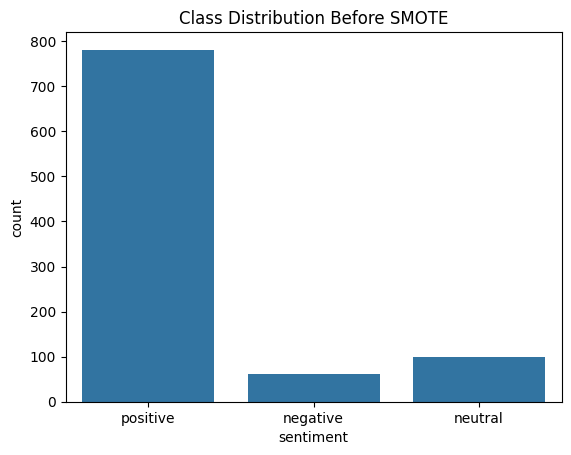

Class distribution after SMOTE: Counter({'positive': 781, 'negative': 781, 'neutral': 781})


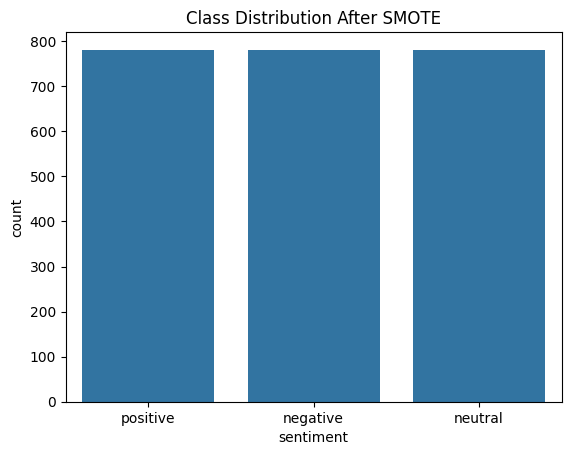

In [21]:

# Check distribution before SMOTE
print("Class distribution before SMOTE:", Counter(y_train))
sns.countplot(x=y_train)
plt.title("Class Distribution Before SMOTE")
plt.show()


# Check distribution after SMOTE
print("Class distribution after SMOTE:", Counter(y_train_res))
sns.countplot(x=y_train_res)
plt.title("Class Distribution After SMOTE")
plt.show()


### Training Logistic Regression on Resampled Data

We train a **Logistic Regression classifier** on the balanced dataset obtained after SMOTE.  

- **`class_weight='balanced'`** is kept, so even with oversampling, the model still adjusts weights inversely proportional to class frequency.  
- **`max_iter=1000`** ensures convergence during training.  
- **`random_state=42`** makes results reproducible.  

By combining **SMOTE + class-weighted Logistic Regression**, we aim to improve prediction quality, especially for **minority classes** (neutral and negative).


In [12]:
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train_res, y_train_res)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

##  Model Evaluation and Visualization

We evaluate the model's predictions on the test set using:

- **Classification report** → precision, recall, and F1-score for each sentiment class.
- **Confusion matrix** → shows correct vs. incorrect predictions.
- **Seaborn heatmap** → visual representation of the confusion matrix for easier interpretation.

These metrics help assess the model’s performance and identify areas for improvement.


Logistic Regression Performance:
              precision    recall  f1-score   support

    negative       0.44      0.53      0.48        15
     neutral       0.84      0.64      0.73        25
    positive       0.94      0.96      0.95       196

    accuracy                           0.90       236
   macro avg       0.74      0.71      0.72       236
weighted avg       0.90      0.90      0.90       236



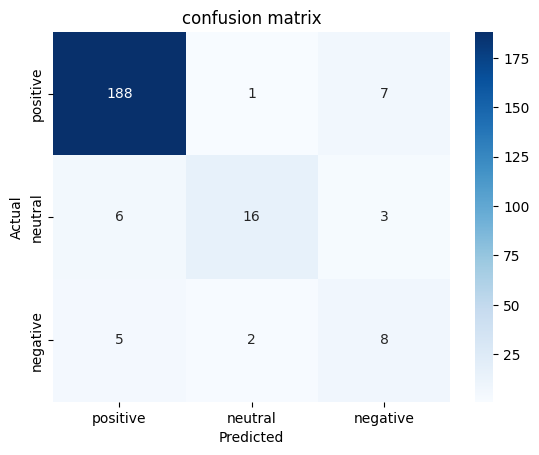

In [13]:
y_pred_lr = model.predict(X_test_vec)
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))
cm = confusion_matrix(y_test, y_pred_lr, labels=["positive", "neutral", "negative"])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["positive", "neutral", "negative"], yticklabels=["positive", "neutral", "negative"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('confusion matrix')
plt.show()

### Logistic Regression Results

- **Precision**: How many predicted positives are actually positive.  
- **Recall**: How many actual positives were correctly identified.  
- **F1-score**: Harmonic mean of precision and recall, balances both.  

From the report:
- **Positive reviews** achieve very high performance (Precision ≈ 0.94, Recall ≈ 0.96).  
- **Neutral reviews** are harder to classify (Recall ≈ 0.64).  
- **Negative reviews** are the most difficult, with lower scores due to class imbalance.  

 The model is good at predicting **positive sentiment**, but struggles with **neutral and negative**, which matches the imbalance in the dataset.

 ### Confusion Matrix Analysis

The confusion matrix shows where the model makes mistakes:

- Most **positive reviews** are predicted correctly.  
- Many **negative and neutral reviews** are misclassified as positive.  
- This confirms that the model is biased towards predicting "positive" sentiment.  



##  Hyperparameter Tuning (GridSearchCV)

To improve performance, we use **GridSearchCV**:
- Tests different parameter combinations (TF-IDF settings, Logistic Regression parameters)
- Uses cross-validation to avoid overfitting
- Selects the best combination automatically

We then retrain the model with the best parameters and re-evaluate.


#### 1) Define an end-to-end Pipeline

We build a leak-safe pipeline:

- **`TfidfVectorizer()`** converts raw text into weighted token features.
- **`LogisticRegression(class_weight='balanced', max_iter=1000)`** helps counter class imbalance by up-weighting minority classes.

> Using a Pipeline means we can tune TF-IDF options and Logistic Regression hyperparameters **together**.


In [14]:
# 1. Define pipeline: TF-IDF + Logistic Regression
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(sampling_strategy='not majority', random_state=42)),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000))
])



#### 2) Set the Parameter Grid

We search across TF-IDF and Logistic Regression hyperparameters:


**tfidf__ngram_range**  ---> Try unigrams only vs. adding bigrams/trigrams to capture short phrases.

**tfidf__max_features** ---> Control vocabulary size to balance expressiveness vs. overfitting/time.

**logreg__C** ---> Regularization strength (smaller = stronger regularization). |
**logreg__solver** --->'liblinear, saga` :  Robust solvers for sparse text;  `saga` scales better, `liblinear` is strong for smaller problems. |


In [15]:
# 2. Define parameter grid (we can tune TF-IDF and LR together!)
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],  # unigrams, bigrams, trigrams
    'tfidf__max_features': [5000, 10000],         # vocab size
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__solver': ['liblinear', 'saga']
}




#### 3) Configure GridSearchCV

- **`scoring='f1_macro'`**: treats all classes equally (important under imbalance).
- **`cv=5`**: 5-fold cross-validation for a stable estimate.
- **`n_jobs=-1`**: use all CPU cores for speed.
- **`verbose=2`**: print progress to monitor long searches.

This setup selects the combination that **maximizes macro-averaged F1** over the CV folds.


In [16]:
# 3. GridSearchCV
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2)


#### 4) Fit on raw training text



In [17]:
grid.fit(X_train, y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('smote',
                                        SMOTE(random_state=42,
                                              sampling_strategy='not '
                                                                'majority')),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.01, 0.1, 1, 10],
                         'logreg__solver': ['liblinear', 'saga'],
                         'tfidf__max_features': [5000, 10000],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='f1_macro', verbose=2)

#### 5) Retrieve the Best Configuration

After the search:

- `grid.best_params_` → the best hyperparameters found.
- `grid.best_estimator_` → the ready-to-use Pipeline (TF-IDF + Logistic Regression) with those params.


In [18]:
# 5. Best model
print("Best Params:", grid.best_params_)
best_model = grid.best_estimator_

Best Params: {'logreg__C': 10, 'logreg__solver': 'saga', 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}


#### 6) Evaluate the Best Model




              precision    recall  f1-score   support

    negative       0.40      0.40      0.40        15
     neutral       0.84      0.64      0.73        25
    positive       0.92      0.95      0.93       196

    accuracy                           0.88       236
   macro avg       0.72      0.66      0.69       236
weighted avg       0.88      0.88      0.88       236



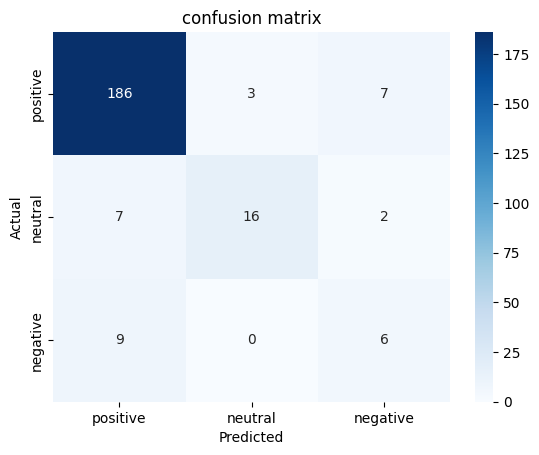

In [19]:
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=["positive", "neutral", "negative"])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["positive", "neutral", "negative"], yticklabels=["positive", "neutral", "negative"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('confusion matrix')
plt.show()

### Final Results with GridSearchCV

The tuned **TF-IDF + Logistic Regression (Pipeline)** model outperforms the baseline:

- **Positive reviews**: very strong performance (high precision and recall).  
- **Neutral reviews**: improved compared to the baseline, but still the hardest class to predict (often confused with positive).  
- **Negative reviews**: moderate improvement, but recall remains lower due to limited training data.  

**Key insights:**
- The **GridSearchCV tuning** (ngram ranges, vocabulary size, regularization `C`, solver) helped the model capture richer patterns in text, boosting overall macro-F1.  



##  Comparison: Logistic Regression + SMOTE vs GridSearchCV + SMOTE

We tested two main approaches to handle class imbalance and optimize our model:

### 1. Logistic Regression + SMOTE (manual resampling before training)  

- Achieves slightly better **macro F1-score**, meaning the performance is more balanced across all classes.  
- Recovers more **negative samples** thanks to SMOTE applied before training.  

### 2. GridSearchCV + SMOTE (SMOTE inside pipeline)

- More **robust and clean approach** .  
- Very high performance on the **majority (positive) class**.  
- Slightly lower **macro F1** compared to Logistic Regression + SMOTE.  
- Recall for the **negative class** is weaker (0.40 vs 0.53).  



**The best model in this case  = Logistic Regression + SMOTE, because it better handles the imbalance and gives higher recall for the minority class.**


###Conclusion

In this project, we built and compared multiple sentiment analysis models on Amazon product reviews.

**Logistic Regression + SMOTE:**

Achieved good overall accuracy (~90%) and strong performance for the positive class.

Improved minority class detection compared to Logistic Regression without SMOTE.

**GridSearchCV + SMOTE (Pipeline):**

Slight improvement in hyperparameter tuning, but overall performance remained close to the simple Logistic + SMOTE model.

Minority classes (neutral and negative) still showed lower precision and recall compared to the positive class.

* Key Insight: Although both approaches reached ~88–90% accuracy, the main challenge remains the imbalance between classes. While SMOTE helped, the model still struggles with negative and neutral sentiments.